In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error

from xgboost import XGBRegressor
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/widsdatathon2022/train.csv
/kaggle/input/widsdatathon2022/test.csv
/kaggle/input/widsdatathon2022/sample_solution.csv


In [2]:
from sklearn.model_selection import train_test_split

# Read the data
X = pd.read_csv("/kaggle/input/widsdatathon2022/train.csv")
X_test_full = pd.read_csv("/kaggle/input/widsdatathon2022/test.csv")

X_test_full.head()

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,...,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,id
0,7,State_1,Commercial,Grocery_store_or_food_market,28484.0,1994.0,37.0,2.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75757
1,7,State_1,Commercial,Grocery_store_or_food_market,21906.0,1961.0,55.0,45.7,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75758
2,7,State_1,Commercial,Grocery_store_or_food_market,16138.0,1950.0,1.0,59.1,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75759
3,7,State_1,Commercial,Grocery_store_or_food_market,97422.0,1971.0,34.0,35.4,38,50.596774,...,0,29,5,2,0,NaN,NaN,NaN,NaN,75760
4,7,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,35.0,1.8,38,50.596774,...,0,29,5,2,0,340.0,330.0,22.8,126.0,75761


In [3]:
# Remove rows with missing target, separate target from predictors
drop_cols = ['january_min_temp', 'january_avg_temp', 'january_max_temp','february_min_temp', 'february_avg_temp',
             'february_max_temp','march_min_temp', 'march_avg_temp', 'march_max_temp', 'april_min_temp',
             'april_avg_temp', 'april_max_temp', 'may_min_temp', 'may_avg_temp','may_max_temp', 'june_min_temp',
             'june_avg_temp', 'june_max_temp','july_min_temp', 'july_avg_temp', 'july_max_temp', 'august_min_temp',
             'august_avg_temp', 'august_max_temp', 'september_min_temp','september_avg_temp', 'september_max_temp',
             'october_min_temp','october_avg_temp', 'october_max_temp', 'november_min_temp','november_avg_temp',
             'november_max_temp', 'december_min_temp','december_avg_temp', 'december_max_temp', 'days_below_0F',
             'days_below_10F', 'days_below_20F', 'days_below_30F', 'days_above_90F', 'days_above_100F', 
             'days_above_110F', 'direction_max_wind_speed', 'max_wind_speed', 'Year_Factor','State_Factor', 
             'precipitation_inches', 'direction_peak_wind_speed', 'days_with_fog', 'building_class', 
             'facility_type', 'snowfall_inches', 'snowdepth_inches']

X = X.drop(drop_cols, axis = 1)
y = X.pop('site_eui')

X.head(10)

,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,avg_temp,days_above_80F,id
0,61242.0,1942.0,11.0,2.4,115,2960,56.972603,14,0
1,274000.0,1955.0,45.0,1.8,115,2960,56.972603,14,1
2,280025.0,1951.0,97.0,1.8,115,2960,56.972603,14,2
3,55325.0,1980.0,46.0,1.8,115,2960,56.972603,14,3
4,66000.0,1985.0,100.0,2.4,115,2960,56.972603,14,4
5,119900.0,1956.0,NaN,2.4,115,2960,56.972603,14,5
6,91367.0,1982.0,56.0,2.4,115,2960,56.972603,14,6
7,50422.0,1947.0,99.0,2.4,115,2960,56.972603,14,7
8,122020.0,1929.0,98.0,2.4,115,2960,56.972603,14,8
9,102612.0,1979.0,83.0,2.4,115,2960,56.972603,14,9


In [4]:
# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, train_size=0.7, test_size=0.3,
                                                                random_state=1)

In [5]:
# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
low_cardinality_cols = [cname for cname in X_train_full.columns if X_train_full[cname].nunique() < 10 and 
                        X_train_full[cname].dtype == "object"]

In [6]:
# Select numeric columns
numeric_cols = [cname for cname in X_train_full.columns if X_train_full[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
my_cols = low_cardinality_cols + numeric_cols
X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()
X_test = X_test_full[my_cols].copy()

X_test.head()

,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,avg_temp,days_above_80F,id
0,28484.0,1994.0,37.0,2.4,342,2112,59.894521,29,75757
1,21906.0,1961.0,55.0,45.7,342,2112,59.894521,29,75758
2,16138.0,1950.0,1.0,59.1,342,2112,59.894521,29,75759
3,97422.0,1971.0,34.0,35.4,342,2112,59.894521,29,75760
4,61242.0,1942.0,35.0,1.8,342,2112,59.894521,29,75761


In [7]:
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[low_cardinality_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_valid.index = X_valid.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(low_cardinality_cols, axis=1)
num_X_valid = X_valid.drop(low_cardinality_cols, axis=1)
num_X_test = X_test.drop(low_cardinality_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

OH_X_test.head(10)

,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,avg_temp,days_above_80F,id
0,28484.0,1994.0,37.0,2.4,342,2112,59.894521,29,75757
1,21906.0,1961.0,55.0,45.7,342,2112,59.894521,29,75758
2,16138.0,1950.0,1.0,59.1,342,2112,59.894521,29,75759
3,97422.0,1971.0,34.0,35.4,342,2112,59.894521,29,75760
4,61242.0,1942.0,35.0,1.8,342,2112,59.894521,29,75761
5,80520.0,1959.0,28.0,18.6,342,2112,59.894521,29,75762
6,46800.0,1941.0,28.0,43.9,342,2112,59.894521,29,75763
7,29094.0,1900.0,41.0,2.4,342,2112,59.894521,29,75764
8,49500.0,1992.0,62.0,2.4,342,2112,59.894521,29,75765
9,67346.0,1967.0,17.0,2.4,342,2112,59.894521,29,75766


In [8]:
# make copy to avoid changing original data (when Imputing)
new_X_train = OH_X_train.copy()
# make new columns indicating what will be imputed
cols_with_missing = (col for col in new_X_train.columns if new_X_train[col].isnull().any())
for col in cols_with_missing:
    new_X_train[col + '_was_missing'] = new_X_train[col].isnull()

# Imputation
my_imputer = SimpleImputer()
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(OH_X_train))
imputed_X_valid = pd.DataFrame(my_imputer.transform(OH_X_valid))

# Imputation removed column names; put them back
imputed_X_train.columns = OH_X_train.columns
imputed_X_valid.columns = OH_X_valid.columns

imputed_X_train.head(10)

,floor_area,year_built,energy_star_rating,ELEVATION,cooling_degree_days,heating_degree_days,avg_temp,days_above_80F,id
0,67373.0,2000.0,60.984556,3.4,1581.0,4460.0,56.835616,106.0,44238.0
1,28126.0,1975.0,44.000000,57.3,260.0,3772.0,55.147541,25.0,72603.0
2,272000.0,1958.0,60.000000,3.4,1581.0,4460.0,56.835616,106.0,44611.0
3,449668.0,1960.0,63.000000,42.7,1489.0,4252.0,57.215847,96.0,61813.0
4,57000.0,1935.0,13.000000,42.7,1128.0,4875.0,54.501370,75.0,41607.0
5,302677.0,1972.0,64.000000,42.7,1277.0,3978.0,57.366120,72.0,21911.0
6,194104.0,1908.0,100.000000,26.5,260.0,3772.0,55.147541,25.0,74416.0
7,100000.0,1916.0,24.000000,18.3,808.0,5889.0,50.634722,95.0,67567.0
8,73668.0,2012.0,100.000000,24.4,1489.0,4252.0,57.215847,96.0,64964.0
9,132017.0,1985.0,38.000000,42.7,1489.0,4252.0,57.215847,96.0,57667.0


In [9]:
# Using Mutual Information
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

avg_temp               0.358747
heating_degree_days    0.357629
days_above_80F         0.354837
cooling_degree_days    0.354774
energy_star_rating     0.244233
id                     0.154801
ELEVATION              0.149381
floor_area             0.093968
year_built             0.068540
Name: MI Scores, dtype: float64


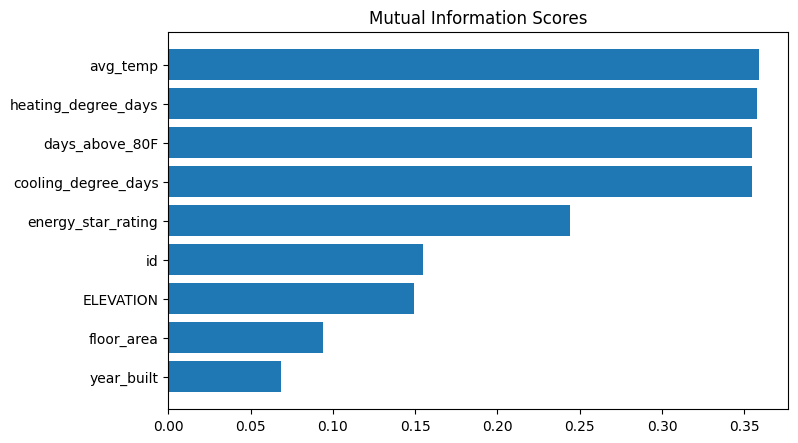

In [10]:
# Evaluate the importance of each feature to the target value
imputed_X_train.drop('id', axis = 1)
mi_scores = make_mi_scores(imputed_X_train, y_train)
print(mi_scores.head(20))

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores.head(20))

In [11]:
# Parameter tuning to find the best values for parameters of the model
def score_dataset(estimators, X_train, X_valid, y_train, y_valid):
    my_model = XGBRegressor(n_estimators = estimators, learning_rate=0.05, random_state = 0)
    my_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
    predictions = my_model.predict(X_valid)
    print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)) + " for n_estimators = " + str(estimators))

In [12]:
results = {}
for i in range(3,8):
    results[200*i] = score_dataset(200*i, imputed_X_train, imputed_X_valid, y_train, y_valid)

Mean Absolute Error: 25.046392082863633 for n_estimators = 600
Mean Absolute Error: 24.87611099590975 for n_estimators = 800
Mean Absolute Error: 24.71327213282633 for n_estimators = 1000
Mean Absolute Error: 24.59048677004201 for n_estimators = 1200
Mean Absolute Error: 24.46624192438307 for n_estimators = 1400


In [13]:
# Final model for predictions
final_model = XGBRegressor(n_estimators = 1400, learning_rate=0.05, max_depth=12, min_child_weight=7,gamma=2,subsample=1,colsample_bytree=0.8, seed=42)
final_model.fit(imputed_X_train, y_train, eval_set=[(imputed_X_valid, y_valid)], verbose=False)

predictions = pd.DataFrame()
predictions['id'] = OH_X_valid.id
predictions["site_eui"] = final_model.predict(OH_X_valid)

In [14]:
submission = final_model.predict(OH_X_test)
SAMPLE_SUBMISSION_PATH = "../input/widsdatathon2022/sample_solution.csv"
SUBMISSION_PATH = "submission.csv"
sub = pd.read_csv(SAMPLE_SUBMISSION_PATH)
sub['site_eui'] = submission
sub.to_csv(SUBMISSION_PATH,index=False)